In [1]:
import torch
import torchvision
import numpy as np
import matplotlib.pyplot as plt
from torchvision.datasets import MNIST
from torchvision.transforms import ToTensor 
from torch.utils.data.sampler import SubsetRandomSampler
from torch.utils.data.dataloader import DataLoader
%matplotlib inline

In [2]:
dataset = MNIST(root = 'data/',
                download=True,
                transform=ToTensor())

In [3]:
def split_indicies(n, val_pct):
    # Determine size of validation set
    n_val = int(val_pct * n)
    # Create random permutation of 0 to n-1
    idxs = np.random.permutation(n)
    # Pick first n_val indicies for validation set
    return idxs[n_val:], idxs[:n_val]

In [4]:
train_indicies, val_indicies = split_indicies(len(dataset), val_pct=0.2)

print(len(train_indicies), len(val_indicies))

48000 12000


In [5]:
batch_szie = 100

# Training sampler and data Loader
train_sampler = SubsetRandomSampler(train_indicies)
train_dl = DataLoader(dataset,
                      batch_szie,
                      sampler=train_sampler)

# Validation sampler and data loader
val_sampler = SubsetRandomSampler(val_indicies)
val_dl = DataLoader(dataset,
                    batch_szie,
                    sampler=val_sampler)

In [6]:
import torch.nn as nn
import torch.nn.functional as F

In [7]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [8]:
class MnistModel(nn.Module):
    """Feedforward neural network with 1 hidden layer"""
    def __init__(self, in_size, hidden_size, out_size):
        super().__init__()
        # hidden layer
        self.linear1 = nn.Linear(in_size, hidden_size)
        # output layer
        self.linear2 = nn.Linear(hidden_size, out_size)
    
    def forward(self, xb):
        # Flatten the image tensors
        xb = xb.view(xb.size(0), -1)
        # Get intermediate outputs using hidden layer
        out = self.linear1(xb)
        # Apply activation function
        out = F.relu(out)
        # Get prediction using output layer
        out = self.linear2(out)
        return out
    
    def training_step(self, batch):
        images, labels = batch
        out = self(images)                  # Generate Predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch
        out = self(images)
        loss = F.cross_entropy(out, labels)
        acc = accuracy(out, labels)
        return {'val_loss': loss, 'val_acc': acc}
    
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()    # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()       # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], val_loss: {:.4f}, val_acc: {:.4f}".format(epoch, result['val_loss'], result['val_acc']))

In [9]:
input_size = 784
num_classes = 10
hidden_size = 32
model = MnistModel(input_size, hidden_size=hidden_size,
                      out_size=num_classes)

In [10]:
for t in model.parameters():
    print(t.shape)

torch.Size([32, 784])
torch.Size([32])
torch.Size([10, 32])
torch.Size([10])


In [11]:
for images, labels in train_dl:
    print("images.shape", images.shape)
    outputs = model(images)
    loss = F.cross_entropy(outputs, labels)
    print('Loss:', loss.item())
    break
print("output shape: ", outputs.shape)
print("sample outputs: \n", torch.sum(F.softmax(outputs[:1].data)))

images.shape torch.Size([100, 1, 28, 28])
Loss: 2.2980916500091553
output shape:  torch.Size([100, 10])
sample outputs: 
 tensor(1.0000)


<ipython-input-11-d44165b7b7c2>:8: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  print("sample outputs: \n", torch.sum(F.softmax(outputs[:1].data)))


In [12]:
def get_default_device():
    """pick GPU if avialable else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')


In [13]:
device = get_default_device()
device

device(type='cpu')

In [14]:
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list, tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

In [15]:
for images, labels in train_dl:
    print(images.shape)
    images = to_device(images, device)
    print(images.device)
    break

torch.Size([100, 1, 28, 28])
cpu


In [16]:
class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
    
    def __iter__(self):
        """Yield a batch of data after moving it to a device"""
        for b in self.dl:
            yield to_device(b, self.device)
    
    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
valid_dl = DeviceDataLoader(val_dl, device)

In [18]:
def evaluate(model, val_loader):
    """Evaluate the model's performance on the validation set"""
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

In [19]:
def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    """Train the model using gradient descent"""
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        
        # Training Phase
        for batch in train_loader:
            loss = model.training_step(batch)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        # Validation Phase
        result = evaluate(model, val_loader)
        model.epoch_end(epoch, result)
        history.append(result)
    return history

In [20]:
# Model (on GPU)
model = MnistModel(input_size, hidden_size=hidden_size, out_size=num_classes)
to_device(model, device)

MnistModel(
  (linear1): Linear(in_features=784, out_features=32, bias=True)
  (linear2): Linear(in_features=32, out_features=10, bias=True)
)

In [21]:
history = [evaluate(model, valid_dl)]
history

[{'val_loss': 2.2984893321990967, 'val_acc': 0.10983332991600037}]

In [22]:
history += fit(5, 0.5, model, train_dl, valid_dl)

Epoch [0], val_loss: 0.2042, val_acc: 0.9384
Epoch [1], val_loss: 0.1668, val_acc: 0.9520
Epoch [2], val_loss: 0.1562, val_acc: 0.9507
Epoch [3], val_loss: 0.1458, val_acc: 0.9581
Epoch [4], val_loss: 0.1461, val_acc: 0.9568


In [23]:
history += fit(5, 0.5, model, train_dl, valid_dl)

Epoch [0], val_loss: 0.1263, val_acc: 0.9629
Epoch [1], val_loss: 0.1255, val_acc: 0.9642
Epoch [2], val_loss: 0.1309, val_acc: 0.9628
Epoch [3], val_loss: 0.1455, val_acc: 0.9592
Epoch [4], val_loss: 0.1512, val_acc: 0.9590


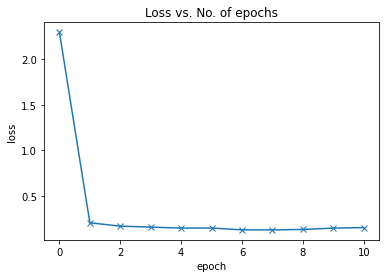

In [24]:
losses = [x['val_loss'] for x in history]
plt.plot(losses, '-x')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('Loss vs. No. of epochs')
plt.show()

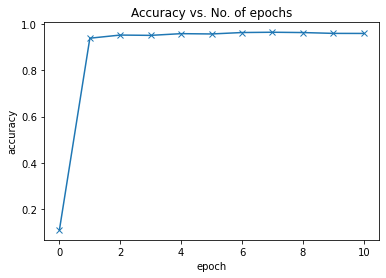

In [25]:
accuracies = [x['val_acc'] for x in history]
plt.plot(accuracies, '-x')
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('Accuracy vs. No. of epochs')
plt.show()

In [26]:
test_dataset = MNIST(root='data/',
                     train=False,
                     transform=ToTensor())

In [27]:
def predict_image(img, model):
    xb = to_device(img.unsqueeze(0), device)
    yb = model(xb)
    _, preds = torch.max(yb, dim=1)
    return preds[0].item()

Label: 2 , Predicted: 2


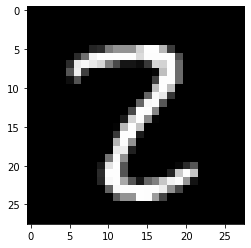

In [28]:
img, label = test_dataset[1839]
plt.imshow(img[0], cmap='gray')
print('Label:', label, ', Predicted:', predict_image(img, model))